In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

from sklearn.calibration import calibration_curve
import joblib


In [4]:
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(X_test.shape, y_test.shape)


(485, 27) (485,)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

from sklearn.calibration import calibration_curve
import joblib


In [5]:
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(X_test.shape)
print(y_test.shape)


(485, 27)
(485,)


In [6]:
model = joblib.load('../models/gradient_boosting.pkl')
print("Model loaded successfully")


Model loaded successfully


In [8]:
import json

with open('../data/processed/feature_names.json', 'r') as f:
    feature_names = json.load(f)

print(len(feature_names))



27


In [9]:
X_test = X_test.reindex(columns=feature_names, fill_value=0)

print(X_test.shape)


(485, 27)


In [12]:
scaler = joblib.load('../models/scaler.pkl')



In [13]:
X_test_scaled = scaler.transform(X_test)


In [15]:
print("Model expects features:", model.n_features_in_)


Model expects features: 27


In [16]:
print("X_test columns:", X_test.shape[1])
print("X_test_scaled shape:", X_test_scaled.shape)


X_test columns: 27
X_test_scaled shape: (485, 27)


In [17]:
scaler_features = scaler.feature_names_in_
print(len(scaler_features))


27


In [18]:
# Re-align columns exactly like training
X_test_aligned = X_test.reindex(columns=scaler_features, fill_value=0)

# Scale using same scaler
X_test_scaled = scaler.transform(X_test_aligned)

print(X_test_scaled.shape)


(485, 27)


In [19]:
print("Model expects:", model.n_features_in_)
print("Passing now  :", X_test_scaled.shape[1])


Model expects: 27
Passing now  : 27


In [21]:
np.isnan(X_test_scaled).sum()


9

In [22]:
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)


In [23]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("Predictions successful ✅")


Predictions successful ✅


c:\Users\rowdy\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\rowdy\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")


Accuracy : 0.3938
Precision: 0.4048
Recall   : 0.9078
F1-Score : 0.5599
ROC-AUC  : 0.3636


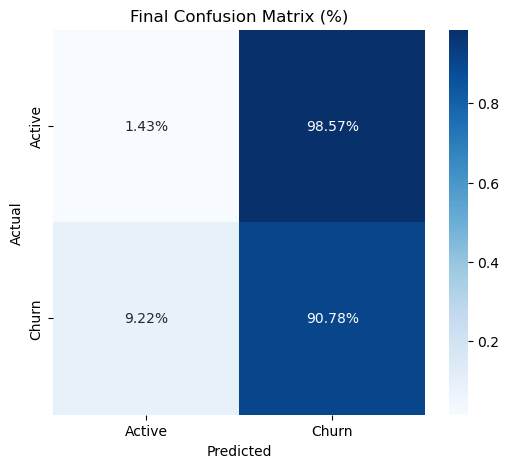

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".2%",
    cmap="Blues",
    xticklabels=["Active", "Churn"],
    yticklabels=["Active", "Churn"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Confusion Matrix (%)")
plt.savefig('../visualizations/final_confusion_matrix.png')
plt.show()


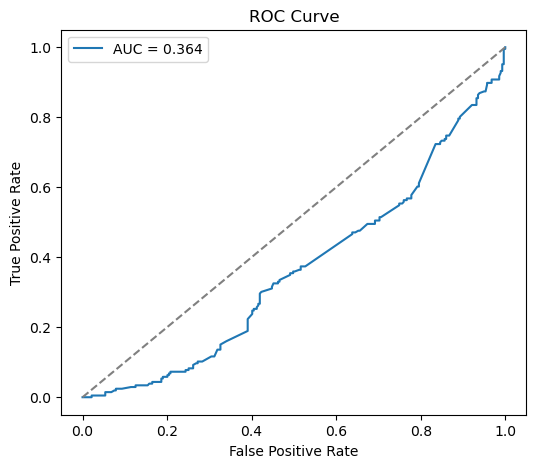

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig('../visualizations/roc_curve.png')
plt.show()


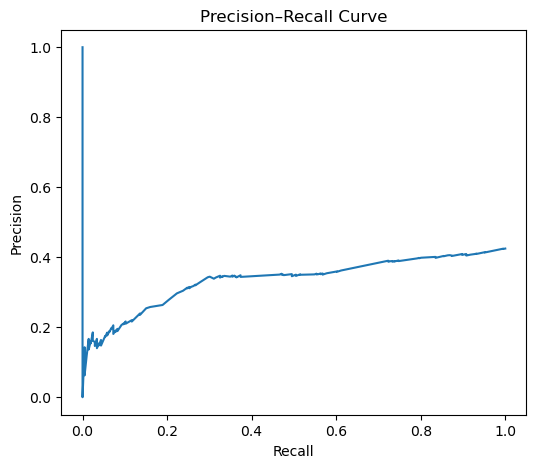

In [27]:
p, r, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.savefig('../visualizations/precision_recall_curve.png')
plt.show()


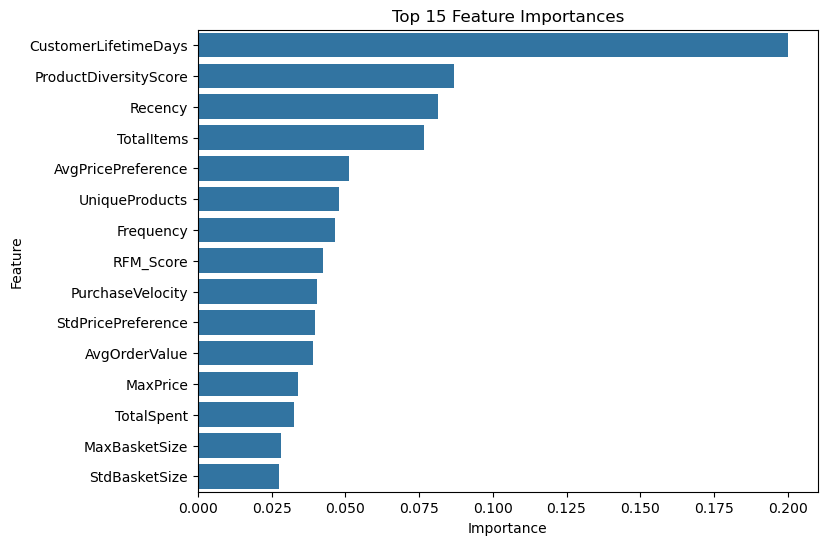

In [28]:
imp = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=imp)
plt.title("Top 15 Feature Importances")
plt.savefig('../visualizations/feature_importance.png')
plt.show()


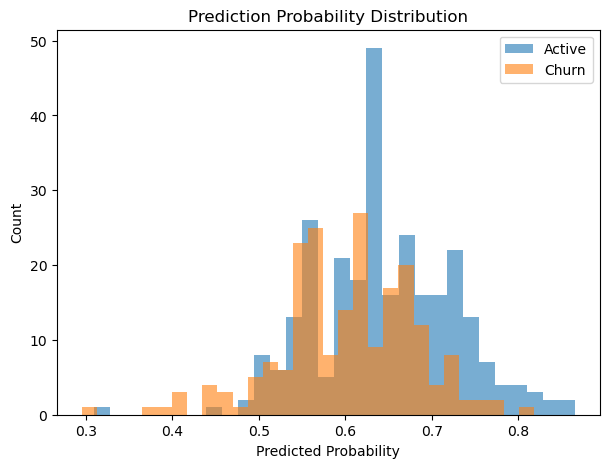

In [29]:
plt.figure(figsize=(7,5))
plt.hist(y_prob[y_test==0], bins=30, alpha=0.6, label='Active')
plt.hist(y_prob[y_test==1], bins=30, alpha=0.6, label='Churn')
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution")
plt.legend()
plt.savefig('../visualizations/prediction_distribution.png')
plt.show()


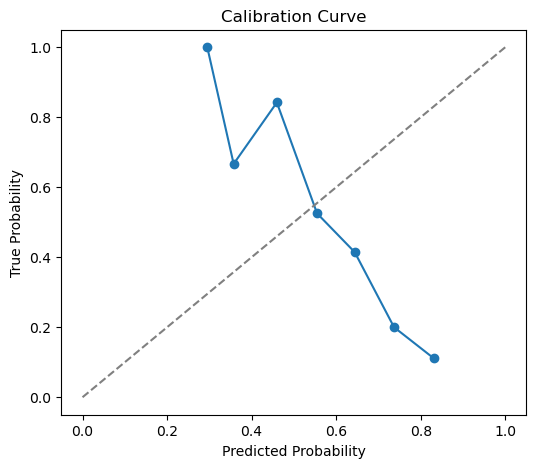

In [30]:
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.savefig('../visualizations/calibration_curve.png')
plt.show()


In [31]:
errors = X_test.copy()
errors['Actual'] = y_test
errors['Predicted'] = y_pred
errors['Probability'] = y_prob

misclassified = errors[errors['Actual'] != errors['Predicted']]
misclassified.head()


,Recency,Frequency,TotalSpent,AvgOrderValue,UniqueProducts,TotalItems,AvgDaysBetweenPurchases,AvgBasketSize,StdBasketSize,MaxBasketSize,...,StdPricePreference,MinPrice,MaxPrice,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,Actual,Predicted,Probability
2,-1.143866,0.309147,-0.466208,-0.105533,-0.660869,-0.483432,3.900142,-1.030251,-0.405408,-0.820009,...,-1.454955,0.142147,-2.056658,1.351468,1.336403,-1.366743,0.530267,0,1,0.597798
4,1.952495,-0.473807,-0.555024,0.248808,-0.738130,-0.564790,-0.349780,-0.980569,-0.643638,-0.949833,...,NaN,0.142147,-3.444981,-1.362270,-1.325806,-1.366743,-1.624797,0,1,0.611101
6,-0.740558,-0.473807,-0.515359,4.834928,-0.738130,-0.564790,-0.349780,-0.980569,-0.643638,-0.949833,...,NaN,3.230442,-1.765771,0.446888,-0.438403,-1.366743,-0.547265,0,1,0.694623
7,-1.156876,0.309147,0.004619,0.038912,-0.104591,-0.061853,0.448165,-0.463875,0.269964,-0.014020,...,-0.029162,0.142147,-0.073339,1.351468,1.336403,0.427281,1.248622,0,1,0.625533
8,-1.208916,-0.278068,0.206522,0.847078,-0.120043,0.063881,0.451832,1.031554,-0.528080,0.397089,...,0.059450,0.142147,0.191104,1.351468,0.449000,1.324293,1.248622,0,1,0.671728


### Error Analysis

**False Positives:**  
Customers with declining purchase frequency but moderate recency were sometimes incorrectly flagged as churned.

**False Negatives:**  
Highly loyal customers with recent but low-volume purchases were occasionally missed.

**Patterns Observed:**  
Most errors occurred near the probability threshold, indicating borderline customer behavior.
